# Data Work

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

In [2]:
# Load dataset
df = pd.read_csv("loan_approval_dataset.csv")
df = df.drop(columns=["loan_id"])
df.columns = df.columns.str.strip()
df.head(3)

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected


In [3]:
df["loan_status"] = df["loan_status"].str.strip().map({'Rejected': 0, 'Approved': 1})

In [4]:
X = df.drop(columns=["loan_status"])
y = df["loan_status"]

In [5]:
# Identify numeric and categorical columns
numerical_cols = X.select_dtypes(include=["int64", "float64"]).columns
categorical_cols = X.select_dtypes(include=["object", "category"]).columns

In [6]:
# One-hot encode categorical columns
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

In [7]:
# Split before scaling
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

In [8]:
# Scale only numerical columns
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

### XGBoost - Classifier

In [9]:
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200]
}

xgb = XGBClassifier(eval_metric='logloss', random_state=42)
grid_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_xgb.fit(X_train, y_train)

print("Best Parameters (XGBoost):", grid_xgb.best_params_)
print("Best Cross-Validation Accuracy:", grid_xgb.best_score_)

Best Parameters (XGBoost): {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}
Best Cross-Validation Accuracy: 0.9827232796486092


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       318
           1       0.98      0.99      0.99       536

    accuracy                           0.98       854
   macro avg       0.98      0.98      0.98       854
weighted avg       0.98      0.98      0.98       854

XGBoost Test Accuracy: 0.9836


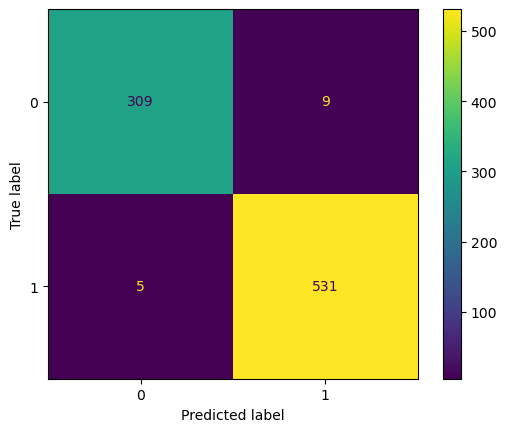

In [10]:
y_pred_xgb = grid_xgb.best_estimator_.predict(X_test)

# Evaluate
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))
print(f"XGBoost Test Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_xgb)).plot()

# CatBoost Classifier

In [11]:
param_grid_cat = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1],
    'iterations': [100, 200]
}

cat = CatBoostClassifier(verbose=0, random_state=42)
grid_cat = GridSearchCV(estimator=cat, param_grid=param_grid_cat, cv=5, scoring='accuracy', n_jobs=-1)
grid_cat.fit(X_train, y_train)

print("Best Parameters (CatBoost):", grid_cat.best_params_)
print("Best Cross-Validation Accuracy:", grid_cat.best_score_)

Best Parameters (CatBoost): {'depth': 6, 'iterations': 200, 'learning_rate': 0.1}
Best Cross-Validation Accuracy: 0.9818448023426061


CatBoost Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       318
           1       0.98      0.99      0.98       536

    accuracy                           0.98       854
   macro avg       0.98      0.98      0.98       854
weighted avg       0.98      0.98      0.98       854

CatBoost Test Accuracy: 0.9801


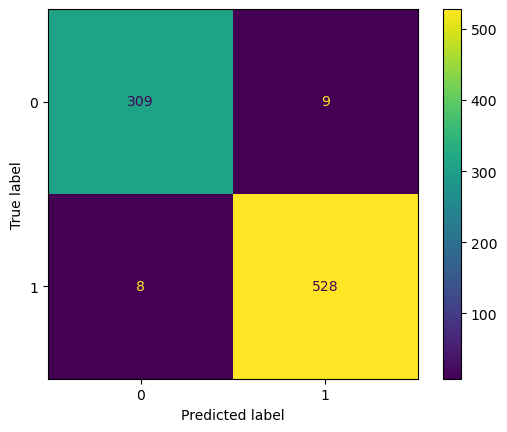

In [12]:
y_pred_cat = grid_cat.best_estimator_.predict(X_test)

# Evaluate
print("CatBoost Classification Report:")
print(classification_report(y_test, y_pred_cat))
print(f"CatBoost Test Accuracy: {accuracy_score(y_test, y_pred_cat):.4f}")
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_cat)).plot()